In [18]:
!pip install torch torchvision matplotlib

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [22]:
full_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

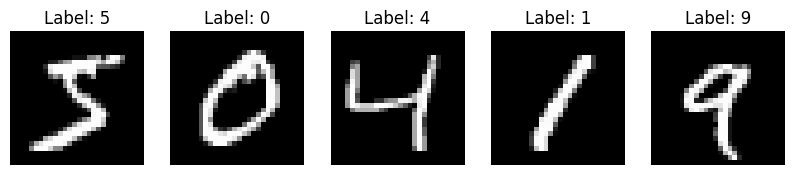

In [23]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

for i in range(5):
    image, label = full_dataset[i]
    image = image.squeeze()  # remove channel dimension -> (28, 28)
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.show()

In [24]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
print(f"Dataset sizes ➜ Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset sizes ➜ Train: 42000, Val: 9000, Test: 9000


In [27]:
class CNNModel(nn.Module):
    def __init__(self, x1=32, m1=3, x2=64, m2=3, x3=128, d=0.5, K=10):
        super(CNNModel, self).__init__()

        # 1st Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=x1, kernel_size=m1)
        # 1st Max Pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional layer
        self.conv2 = nn.Conv2d(in_channels=x1, out_channels=x2, kernel_size=m2)
        # 2nd Max Pooling layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected layer
        self.fc1 = nn.Linear(x2 * 5 * 5, x3)  # 28x28 → conv+pool reduce to 5x5
        self.dropout = nn.Dropout(d)
        # Output layer
        self.fc2 = nn.Linear(x3, K)

    def forward(self, x):
        # Convolution + ReLU + Pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected + Dropout + Output
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # Softmax for classification
        return F.log_softmax(x, dim=1)

# Instantiate the model
model = CNNModel().to(device)
print(model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, training: bool):
    if training:
        model.train()
    else:
        model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0
    with torch.set_grad_enabled(training):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            if training:
                optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            if training:
                loss.backward()
                optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return epoch_loss / total, correct / total

num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

Epoch 01/20 | Train Loss: 1.2992 Acc: 61.92% | Val Loss: 0.3764 Acc: 89.24%
Epoch 02/20 | Train Loss: 0.3635 Acc: 89.45% | Val Loss: 0.2025 Acc: 93.99%
Epoch 03/20 | Train Loss: 0.2429 Acc: 92.91% | Val Loss: 0.1413 Acc: 95.92%
Epoch 04/20 | Train Loss: 0.1883 Acc: 94.51% | Val Loss: 0.1116 Acc: 96.73%
Epoch 05/20 | Train Loss: 0.1589 Acc: 95.39% | Val Loss: 0.0957 Acc: 97.24%
Epoch 06/20 | Train Loss: 0.1398 Acc: 95.87% | Val Loss: 0.0885 Acc: 97.36%
Epoch 07/20 | Train Loss: 0.1233 Acc: 96.53% | Val Loss: 0.0813 Acc: 97.43%
Epoch 08/20 | Train Loss: 0.1131 Acc: 96.66% | Val Loss: 0.0694 Acc: 97.68%
Epoch 09/20 | Train Loss: 0.1049 Acc: 96.99% | Val Loss: 0.0660 Acc: 97.78%
Epoch 10/20 | Train Loss: 0.0973 Acc: 97.08% | Val Loss: 0.0621 Acc: 97.82%
Epoch 11/20 | Train Loss: 0.0923 Acc: 97.37% | Val Loss: 0.0632 Acc: 97.99%
Epoch 12/20 | Train Loss: 0.0847 Acc: 97.53% | Val Loss: 0.0589 Acc: 98.12%
Epoch 13/20 | Train Loss: 0.0827 Acc: 97.62% | Val Loss: 0.0551 Acc: 98.21%
Epoch 14/20 

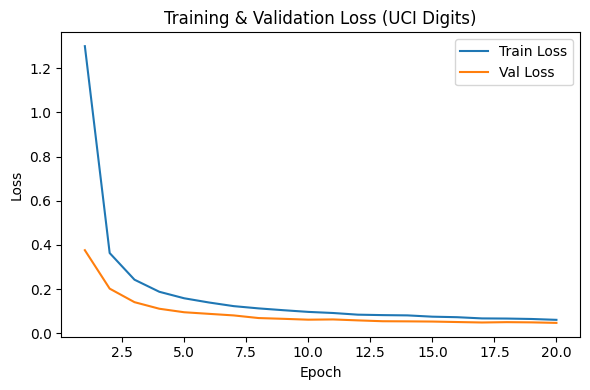

In [29]:
for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, training=True)
    va_loss, va_acc = run_epoch(val_loader,   training=False)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);   val_accs.append(va_acc)

    print(f"Epoch {epoch:02d}/{num_epochs} "
          f"| Train Loss: {tr_loss:.4f} Acc: {tr_acc*100:5.2f}% "
          f"| Val Loss: {va_loss:.4f} Acc: {va_acc*100:5.2f}%")

# Plot training & validation loss vs epoch (Q7)
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (UCI Digits)")
plt.legend()
plt.tight_layout()
plt.show()

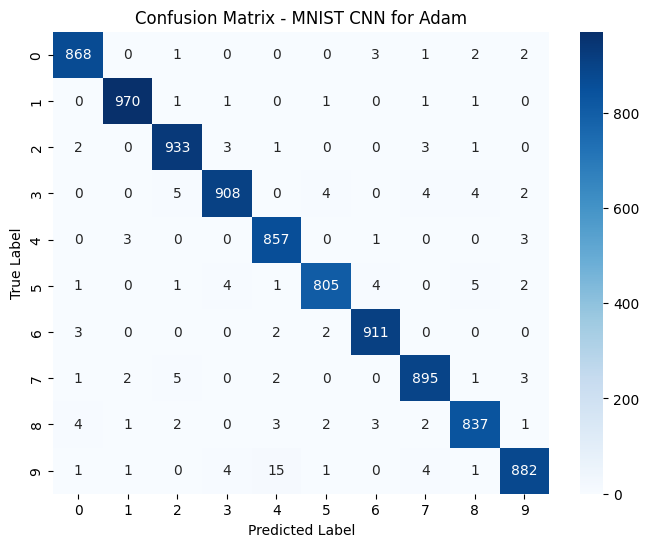

In [32]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MNIST CNN for Adam')
plt.show()